In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import cluster

从台词推测是出自悲剧/喜剧/历史剧.参考:
* [Building a Genre Classifier for Shakespeare Speeches](http://www.adampalay.com/notebooks/shakespeare-genre-classifier.html)
* [Text Mining the Complete Works of William Shakespeare](http://www.r-bloggers.com/text-mining-the-complete-works-of-william-shakespeare/)

In [4]:
# 从搜集到的 xml 转成了 dataframe, 输出了 csv 
lines_all = pd.read_csv('lines_all.csv')

In [5]:
lines_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100731 entries, 0 to 100730
Data columns (total 4 columns):
Unnamed: 0      100731 non-null int64
genre           100731 non-null object
plays_name      100731 non-null object
speech_lines    100731 non-null object
dtypes: int64(1), object(3)
memory usage: 3.8+ MB


In [6]:
lines_all.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
lines_all.head()

,genre,plays_name,speech_lines
0,comedy,All’s Well That Ends Well,"In delivering my son from me, I bury a second ..."
1,comedy,All’s Well That Ends Well,"And I in going, madam, weep o’er my father’s d..."
2,comedy,All’s Well That Ends Well,"You shall find of the King a husband, madam; y..."
3,comedy,All’s Well That Ends Well,What hope is there of his Majesty’s amendment?
4,comedy,All’s Well That Ends Well,"He hath abandon’d his physicians, madam, under..."


参考 `sklearn` 中如何处理文本数据
* http://scikit-learn.org/stable/modules/feature_extraction.html
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

另外需要处理文本数据的话, 可以用到 `nltk` 这个包, 参考
* [nltk 官网](http://www.nltk.org/)
* [Natural Language Processing with Python](http://www.nltk.org/book/)
* [demo](http://text-processing.com/demo/)

In [8]:
X_all = lines_all.speech_lines
Y_all = lines_all.genre

In [9]:
# split train, test
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X_all, Y_all, train_size=0.8)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [11]:
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
X_train_counts.shape

(80584, 21390)

In [12]:
# 一个巨大的 matrix
count_vec.vocabulary_.get(u'love')

11079

In [13]:
# use tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(80584, 21390)

In [14]:
# multinomial variant in naive bayes classifier
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, Y_train)

In [15]:
# 对 test data 处理为 tfidf, 进行 predict
X_test_counts = count_vec.transform(X_test)
X_test_counts.shape

(20147, 21390)

In [16]:
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [17]:
Y_predicted = clf.predict(X_test_tfidf)

In [18]:
np.mean(Y_predicted == Y_test)

0.53605995929915129

In [19]:
# 准确率比较低, 换linear SVM, 被认为是 best text classification algorithm
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier().fit(X_train_tfidf, Y_train)

In [20]:
Y_predicted_svm = clf.predict(X_test_tfidf)

In [21]:
np.mean(Y_predicted_svm == Y_test)

0.53387601131682139

In [22]:
# 额 并没有提高
import nltk
from nltk.stem import PorterStemmer
import string

In [23]:
# 使用 stemming
stemmer = PorterStemmer()
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
    # strip out punctuation and make lowercase
    tokens = [token.lower().strip(string.punctuation)
              for token in tokens if token.isalnum()]

    # now stem the tokens
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

In [24]:
count_vec2 = CountVectorizer(tokenizer = tokenize_and_stem)

In [1]:
# nltk data 要先 download
X_train_tokenized = count_vec2.fit_transform(X_train)

clf = MultinomialNB()
clf.fit(X_train_tokenized, Y_train)

NameError: name 'count_vec2' is not defined

In [35]:
# grid search to determine parameters

from sklearn.grid_search import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-1, 1e-3),}

In [26]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),])

In [36]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [37]:
gs_clf = gs_clf.fit(X_train[:10000],Y_train[:10000])

In [38]:
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])

In [39]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 2)


In [40]:
Y_predicted_gs = gs_clf.predict(X_test)

In [41]:
np.mean(Y_predicted_gs==Y_test)

0.46289770189110041

In [42]:
# 额 分类效果反而变差.....= =||| why?

In [43]:
# 假设没有 genre, 对台词进行聚类, cluster
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans

In [48]:
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                 min_df=0.001, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(80584, 650)

In [49]:
from sklearn.preprocessing import Normalizer

# 用 truncated SVD 降维

svd = TruncatedSVD(100) # desired dimensionality, for LSA, 100 better
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [50]:
X_train_tfidf = lsa.fit_transform(X_train_tfidf)
svd.explained_variance_ratio_.sum() # explained variance of SVD step

0.42105557581780678

In [51]:
X_train_tfidf.shape

(80584, 100)

In [61]:
true_k = 3 # 实际有3种分类
km = KMeans(n_clusters = true_k, init='k-means++', n_init=1, max_iter=50000)

km.fit(X_train_tfidf)

KMeans(copy_x=True, init='k-means++', max_iter=50000, n_clusters=3, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [62]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y_train, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(Y_train, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(Y_train, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(Y_train, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train_tfidf, km.labels_, sample_size=1000))


Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand-Index: 0.000
Silhouette Coefficient: 0.065


In [63]:
#可以看到聚类效果挺差的, Silhouette Coefficient接近于0 表示有重合的部分 overlapping cluster
# 尝试 minibatch kmeans

minikm = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, max_iter=50000)
minikm.fit(X_train_tfidf)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=50000, max_no_improvement=10,
        n_clusters=3, n_init=1, random_state=None, reassignment_ratio=0.01,
        tol=0.0, verbose=0)

In [64]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y_train, minikm.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(Y_train, minikm.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(Y_train, minikm.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(Y_train, minikm.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train_tfidf, minikm.labels_, sample_size=1000))


Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand-Index: 0.000
Silhouette Coefficient: 0.044


In [65]:
# 和 K means 情况差不多, cluster 效果不好....

In [72]:
# visualization

count_vector = CountVectorizer()
term_count = count_vector.fit_transform(X_all)
term_count.shape

(100731, 23182)

In [119]:
# count_vector.vocabulary_

In [76]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(term_count)

In [77]:
tfidf[1:10,1:10].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.25858974,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [79]:
tfidf.shape # 每一行为一个 document 也就是一句台词, 每一列为一个单词

(100731, 23182)

In [80]:
tfidf

<100731x23182 sparse matrix of type '<type 'numpy.float64'>'
	with 786176 stored elements in Compressed Sparse Row format>

In [85]:
print tfidf.max()

1.0


In [88]:
tfidf.todense(order='C').shape

(100731, 23182)

In [94]:
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                 min_df=0.005, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
vec_tfidf = tfidf_vectorizer.fit_transform(X_all)
vec_tfidf.shape

(100731, 81)

In [95]:
tfidf_vectorizer.vocabulary_ # 觉得应该把一个play下的放一起....

{u'art': 0,
 u'away': 1,
 u'ay': 2,
 u'bear': 3,
 u'better': 4,
 u'blood': 5,
 u'brother': 6,
 u'come': 7,
 u'comes': 8,
 u'day': 9,
 u'dead': 10,
 u'death': 11,
 u'did': 12,
 u'doth': 13,
 u'duke': 14,
 u'er': 15,
 u'eyes': 16,
 u'fair': 17,
 u'father': 18,
 u'fear': 19,
 u'god': 20,
 u'good': 21,
 u'grace': 22,
 u'great': 23,
 u'hand': 24,
 u'hast': 25,
 u'hath': 26,
 u'head': 27,
 u'hear': 28,
 u'heart': 29,
 u'heaven': 30,
 u'honor': 31,
 u'king': 32,
 u'know': 33,
 u'lady': 34,
 u'leave': 35,
 u'let': 36,
 u'life': 37,
 u'like': 38,
 u'little': 39,
 u'live': 40,
 u'll': 41,
 u'long': 42,
 u'look': 43,
 u'lord': 44,
 u'love': 45,
 u'madam': 46,
 u'make': 47,
 u'man': 48,
 u'master': 49,
 u'men': 50,
 u'nay': 51,
 u'night': 52,
 u'noble': 53,
 u'old': 54,
 u'peace': 55,
 u'poor': 56,
 u'pray': 57,
 u'say': 58,
 u'shall': 59,
 u'sir': 60,
 u'son': 61,
 u'speak': 62,
 u'st': 63,
 u'stand': 64,
 u'sweet': 65,
 u'tell': 66,
 u'th': 67,
 u'thee': 68,
 u'thing': 69,
 u'think': 70,
 u'thou

In [113]:
for line in X_all[:10]:
    print line


In delivering my son from me, I bury a second husband.

And I in going, madam, weep o’er my father’s death anew; but I must attend his Majesty’s command, to whom I am now in ward, evermore in subjection.

You shall find of the King a husband, madam; you, sir, a father. He that so generally is at all times good must of necessity hold his virtue to you, whose worthiness would stir it up where it wanted rather than lack it where there is such abundance.

What hope is there of his Majesty’s amendment?

He hath abandon’d his physicians, madam, under whose practices he hath persecuted time with hope, and finds no other advantage in the process but only the losing of hope by time.

This young gentlewoman had a father—O, that “had,” how sad a passage ’tis!—whose skill was almost as great as his honesty; had it stretch’d so far, would have made nature immortal, and death should have play for lack of work. Would for the King’s sake he were living! I think it would be the death of the King’s dis

In [114]:
for line in X_all:
    with open('text.txt', 'a+') as f:
        f.write('\n'+line)

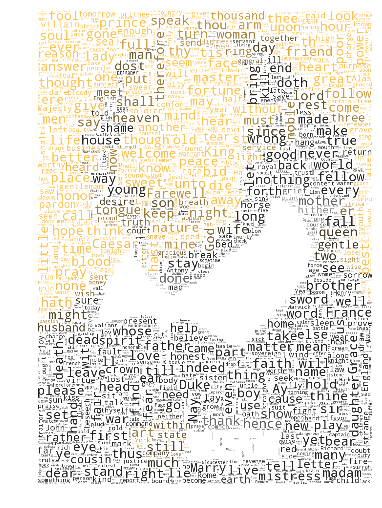

In [115]:
%run wc_poster.py